• Examine Sephora dataset, figure out distribution of authors vs number of reviews given

## Make connections and load data

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the dataset manually from Kaggle: https://www.kaggle.com/nadyinky/sephora-products-and-skincare-reviews

# Unzip the downloaded file
# Replace '/path/to/downloaded/file.zip' with the path where you downloaded the file
!unzip /path/to/downloaded/file.zip -d /content/

 90% 132M/147M [00:00<00:00, 159MB/s]
100% 147M/147M [00:01<00:00, 138MB/s]
Archive:  /content/sephora-products-and-skincare-reviews.zip
  inflating: product_info.csv        
  inflating: reviews_0-250.csv       
  inflating: reviews_1250-end.csv    
  inflating: reviews_250-500.csv     
  inflating: reviews_500-750.csv     
  inflating: reviews_750-1250.csv    


### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# table paths
product_path = '/content/product_info.csv'
review_250path = '/content/reviews_0-250.csv'
review_1250endpath = '/content/reviews_1250-end.csv'
review_250_500path = '/content/reviews_250-500.csv'
review_500_750path ='/content/reviews_500-750.csv'
review_750_1250path = '/content/reviews_750-1250.csv'

In [ ]:
# read csv
product_df = pd.read_csv(product_path)
review_250df = pd.read_csv(review_250path,  dtype={1: str })
review_1250enddf = pd.read_csv(review_1250endpath, dtype={1: str })
review_250_500df = pd.read_csv(review_250_500path, dtype={1: str })
review_500_750df = pd.read_csv(review_500_750path, dtype={1: str })
review_750_1250df = pd.read_csv(review_750_1250path, dtype={1: str })

*Note: reviews 0-250: reviews of 250 products are collected*

In [ ]:
# view head of product_df
product_df.shape

(8494, 27)

*Note: The review tables only show reviews for **skin care** products, therefore we want to drop or eliminate poroducts that do not belong to this category.*

In [ ]:
# look at the first 5 rows
review_1250enddf.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1945004256,5,1.0,0.000000,2,2,0,2022-12-10,I absolutely L-O-V-E this oil. I have acne pro...,A must have!,lightMedium,green,combination,NaN,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
1,1,5478482359,3,1.0,0.333333,3,2,1,2021-12-17,I gave this 3 stars because it give me tiny li...,it keeps oily skin under control,mediumTan,brown,oily,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
2,2,29002209922,5,1.0,1.000000,2,0,2,2021-06-07,Works well as soon as I wash my face and pat d...,Worth the money!,lightMedium,brown,dry,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
3,3,7391078463,5,1.0,1.000000,2,0,2,2021-05-21,"this oil helped with hydration and breakouts, ...",best face oil,lightMedium,brown,combination,blonde,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
4,4,1766313888,5,1.0,1.000000,13,0,13,2021-03-29,This is my first product review ever so that s...,Maskne miracle,mediumTan,brown,combination,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0


In [ ]:
# drop unecessary columns to our skincare investigation
cols_to_drop = ['Unnamed: 0','hair_color','eye_color','skin_tone']
review_250df.drop(cols_to_drop, axis=1, inplace=True)
review_1250enddf.drop(cols_to_drop, axis=1, inplace=True)
review_250_500df.drop(cols_to_drop, axis=1, inplace=True)
review_500_750df.drop(cols_to_drop, axis=1, inplace=True)
review_750_1250df.drop(cols_to_drop, axis=1, inplace=True)


In [ ]:
print('Review tables shape:')
print(review_250df.shape)
print(review_1250enddf.shape)
print(review_250_500df.shape)
print(review_500_750df.shape)
print(review_750_1250df.shape)

Review tables shape:
(602130, 15)
(49977, 15)
(206725, 15)
(116262, 15)
(119317, 15)


In [ ]:
# look at the first 5 rows
review_250df.head()

,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_type,product_id,product_name,brand_name,price_usd
0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,dry,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,dry,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,combination,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,combination,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


Take a look at the product category present in product_df dataframe, we are only interested in skincare product. Therefore, it would be beneficial to remove those that are not in our desired category.

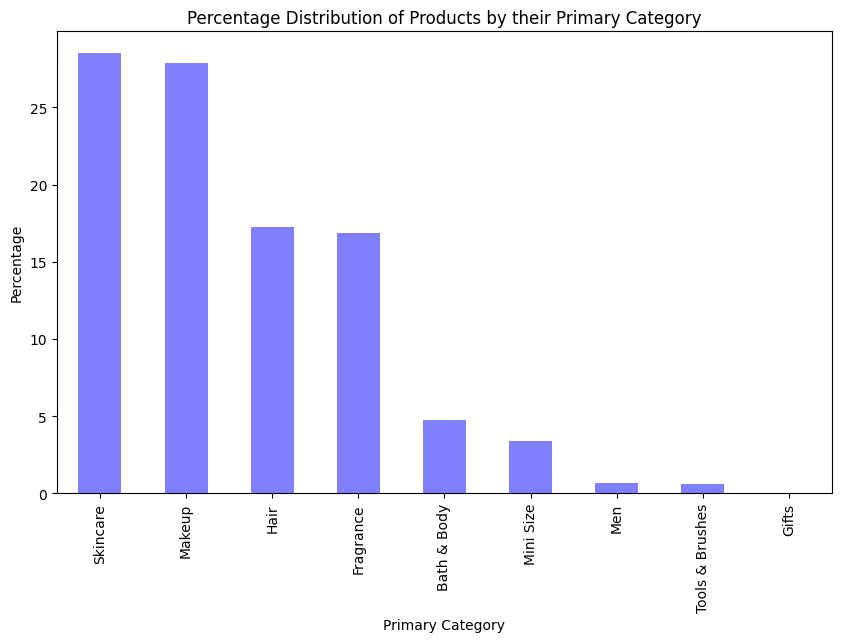

In [ ]:
# bar plot of products in dataframe
counts = product_df['primary_category'].value_counts()
percentages = (counts / counts.sum())*100

plt.figure(figsize=(10, 6))
percentages.plot(kind='bar', title='Percentage Distribution of Products by their Primary Category',color='blue',alpha=.5)
plt.ylabel('Percentage')
plt.xlabel('Primary Category')
plt.show()

It is good to see that the majority of products present are skincare, now we will go ahead and remove all the other categories.

In [ ]:
# drop all rows that are not skincare as primary category
product_df= product_df[product_df['primary_category']=='Skincare']
print(product_df.shape)

(2420, 27)


In [ ]:
# observe columns after isolation
product_df.columns

Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price'],
      dtype='object')

In [ ]:
# change name of column reviews
product_df.rename(columns={'reviews':'num_reviews',
                          'price_usd':'original_price_usd',
                           'rating':'average_rating'}, inplace=True)

<ipython-input-15-8fad8f2edc84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_df.rename(columns={'reviews':'num_reviews',


The 'wellness', 'high tech tools' and 'self tanners', secondary category of products is not within the scope of our current investigation. This category includes items like supplements and tools such as rollers. Our primary research and analysis are centered on products like creams, serums, toners, etc., which are chemically formulated to be applied to the face and address specific skincare concerns over time. As a result, we won't be conducting an in-depth examination of the 'wellness','high tech tools', and 'self tanners' categories at this time.

In [ ]:
# drop rows in secondary category products_df we wont be using
values_to_drop = ['Self Tanners','High Tech Tools','Wellness','Shop by Concern','Mini Size','Value & Gift Sets']
product_df = product_df[~product_df['secondary_category'].isin(values_to_drop)]

Combining similar categories may enhance the clarity of analysis and visualization. "Lip Balms & Treatments" are typically regarded as forms of treatment, and its differentiation from the "Treatments" category does not substantially impact the analysis, grouping them together could be beneficial.

In [ ]:
# combining treatments
categories_to_rename = ['Treatments', 'Lip Balms & Treatments']
product_df['secondary_category'] = product_df['secondary_category'].replace(categories_to_rename, 'Treatments & Serums')

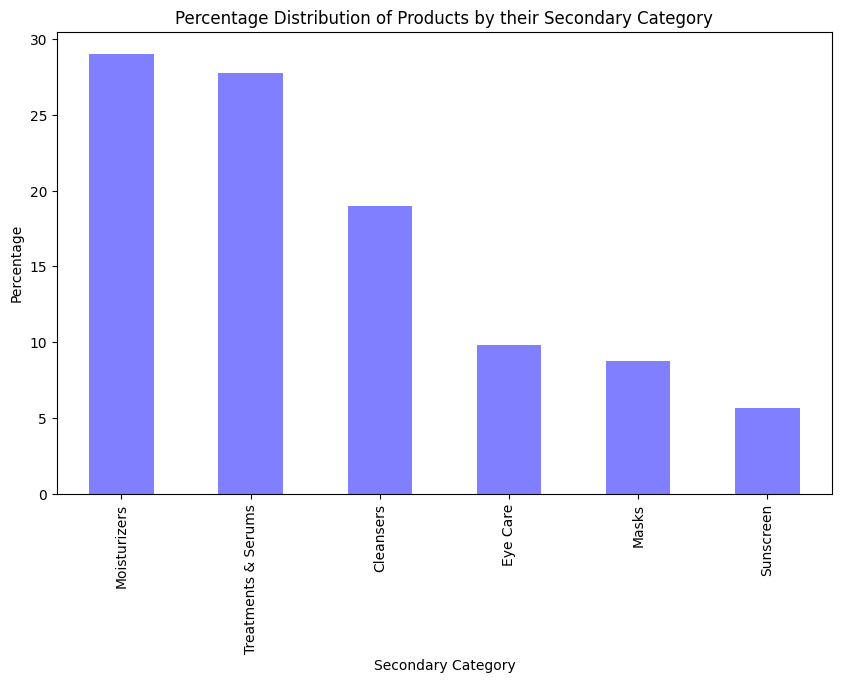

In [ ]:
# secondary category of product distribution
counts = product_df['secondary_category'].value_counts()
percentages = (counts / counts.sum())*100

plt.figure(figsize=(10, 6))
percentages.plot(kind='bar', title='Percentage Distribution of Products by their Secondary Category',color='blue',alpha=.5)
plt.ylabel('Percentage')
plt.xlabel('Secondary Category')
plt.show()

In [ ]:
# drop rows in tertiary category products_df we wont be using
values_to_drop = ['Facial Rollers','BB & CC Creams','Face Wipes','Makeup Removers','Holistic Wellness', 'Teeth Whitening','Blotting Papers','Hair Removal','Beauty Supplements']
product_df = product_df[~product_df['tertiary_category'].isin(values_to_drop)]

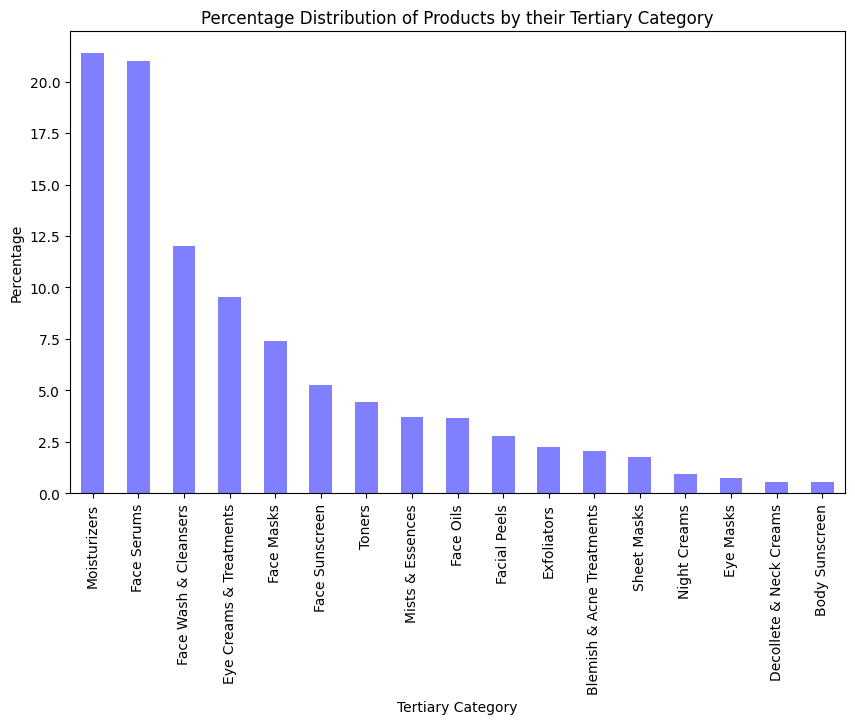

In [ ]:
# tertiary category of product distribution
counts = product_df['tertiary_category'].value_counts()
percentages = (counts / counts.sum())*100

plt.figure(figsize=(10, 6))
percentages.plot(kind='bar', title='Percentage Distribution of Products by their Tertiary Category',color='blue',alpha=.5)
plt.ylabel('Percentage')
plt.xlabel('Tertiary Category')
plt.show()

*Note: While products may be marketed for specific areas of the body, it's important to note that they often contain ingredients that address broader skincare concerns.*

In [ ]:
# check duplicated in products table -> product ids
duplicated_products = product_df[product_df.duplicated(['product_id'])]
duplicated_products

,product_id,product_name,brand_id,brand_name,loves_count,average_rating,num_reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price


In [ ]:
# missing values on products table
sum_na = product_df.isna().sum()
percent_missing = sum_na/len(product_df)*100
percent_missing.sort_values(ascending=False)

value_price_usd       99.413333
variation_desc        99.360000
sale_price_usd        98.613333
child_max_price       81.706667
child_min_price       81.706667
highlights            16.746667
variation_value        6.026667
variation_type         4.533333
tertiary_category      3.626667
size                   3.146667
average_rating         1.920000
num_reviews            1.920000
ingredients            1.706667
sephora_exclusive      0.000000
brand_id               0.000000
child_count            0.000000
secondary_category     0.000000
primary_category       0.000000
new                    0.000000
out_of_stock           0.000000
online_only            0.000000
limited_edition        0.000000
brand_name             0.000000
product_name           0.000000
original_price_usd     0.000000
loves_count            0.000000
product_id             0.000000
dtype: float64

In [ ]:
# Concatenate all review DataFrames vertically
all_reviews = pd.concat([review_250df, review_1250enddf, review_250_500df, review_500_750df, review_750_1250df], ignore_index=True)

In [ ]:
# get rid of products with no ingredients
product_df = product_df[product_df['ingredients'].notna()]

In [ ]:
# missing values on review table
sum_na = all_reviews.isna().sum()
percent_missing = sum_na/len(all_reviews)*100
percent_missing.sort_values(ascending=False)

helpfulness                 51.314543
review_title                28.385497
is_recommended              15.349626
skin_type                   10.193337
review_text                  0.131943
author_id                    0.000000
rating                       0.000000
total_feedback_count         0.000000
total_neg_feedback_count     0.000000
total_pos_feedback_count     0.000000
submission_time              0.000000
product_id                   0.000000
product_name                 0.000000
brand_name                   0.000000
price_usd                    0.000000
dtype: float64

In [ ]:
# impute skin_type by most common
mode_skin_type = all_reviews['skin_type'].mode()[0]  # Get the most common skin_type value
all_reviews['skin_type'].fillna(mode_skin_type, inplace=True)

# Check if all missing skin_type values have been imputed
missing_skin_type_count = all_reviews['skin_type'].isnull().sum()
print(f"Number of missing skin_type values after imputation: {missing_skin_type_count}")

Number of missing skin_type values after imputation: 0


In [ ]:
print(f'Shape of Concatenated Reviews Dataframe: {all_reviews.shape}\nFirst 5 rows:')
all_reviews.head()

Shape of Concatenated Reviews Dataframe: (1094411, 15)
First 5 rows:


,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_type,product_id,product_name,brand_name,price_usd
0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,dry,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,combination,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,dry,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,combination,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,combination,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [ ]:
# renaming of columns to prevent overlap with purchase
all_reviews.rename(columns={'price_usd':'purchase_price_usd',
                           'rating':'author_rating'}, inplace=True)

In [ ]:
# merge product table and review table
cols_join = ['product_id','product_name','brand_name']
merged_df = pd.merge(product_df, all_reviews, on=cols_join, how='inner')

We will perform an **INNER JOIN** to retain only those products that have received reviews. The reviews table contains more reviewed products than the total number of products in our products table. Initially, I filtered products from the products table based on their secondary and tertiary categories to identify those relevant to skincare for our analysis. Consequently, there is a possibility that we have reviews on the reviews table for products that do not fall within the scope of our skincare investigation.


In [ ]:
# new shape of merged tables
print(f'Shape of Merged Product and Review Table:\n{merged_df.shape}\nColumn names:')
merged_df.columns

Shape of Merged Product and Review Table:
(930452, 39)
Column names:


Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'average_rating', 'num_reviews', 'size', 'variation_type',
       'variation_value', 'variation_desc', 'ingredients',
       'original_price_usd', 'value_price_usd', 'sale_price_usd',
       'limited_edition', 'new', 'online_only', 'out_of_stock',
       'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price', 'author_id', 'author_rating',
       'is_recommended', 'helpfulness', 'total_feedback_count',
       'total_neg_feedback_count', 'total_pos_feedback_count',
       'submission_time', 'review_text', 'review_title', 'skin_type',
       'purchase_price_usd'],
      dtype='object')

In [ ]:
# missing values on review table
sum_na = merged_df.isna().sum()
percent_missing = sum_na/len(merged_df)*100
percent_missing.sort_values(ascending=False)

variation_desc              99.113872
sale_price_usd              99.015210
value_price_usd             97.577199
child_max_price             55.422526
child_min_price             55.422526
helpfulness                 52.109405
review_title                28.341817
is_recommended              15.702583
highlights                  10.734138
tertiary_category            6.721357
variation_value              4.151208
variation_type               3.462726
size                         2.563163
review_text                  0.129292
author_id                    0.000000
author_rating                0.000000
product_id                   0.000000
total_neg_feedback_count     0.000000
total_feedback_count         0.000000
total_pos_feedback_count     0.000000
submission_time              0.000000
skin_type                    0.000000
child_count                  0.000000
sephora_exclusive            0.000000
secondary_category           0.000000
primary_category             0.000000
product_name

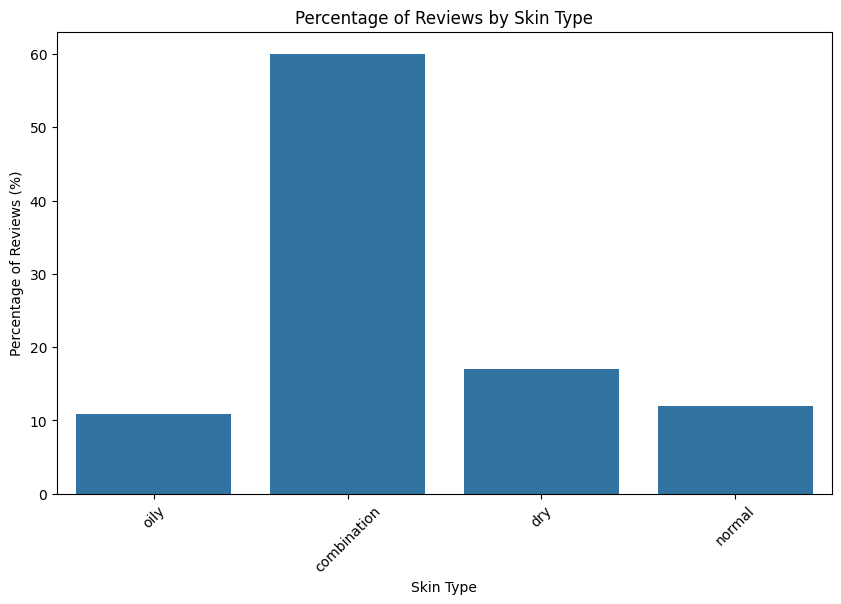

In [ ]:
# Calculate the total number of reviews
total_reviews = len(merged_df)

# Calculate the percentage of reviews for each skin type
merged_df['skin_type_percentage'] = merged_df.groupby('skin_type')['skin_type'].transform(lambda x: len(x) / total_reviews * 100)

# Plot the percentage of reviews by skin type
plt.figure(figsize=(10, 6))
sns.barplot(x='skin_type', y='skin_type_percentage', data=merged_df)
plt.title('Percentage of Reviews by Skin Type')
plt.xlabel('Skin Type')
plt.ylabel('Percentage of Reviews (%)')
plt.xticks(rotation=45)
plt.show()


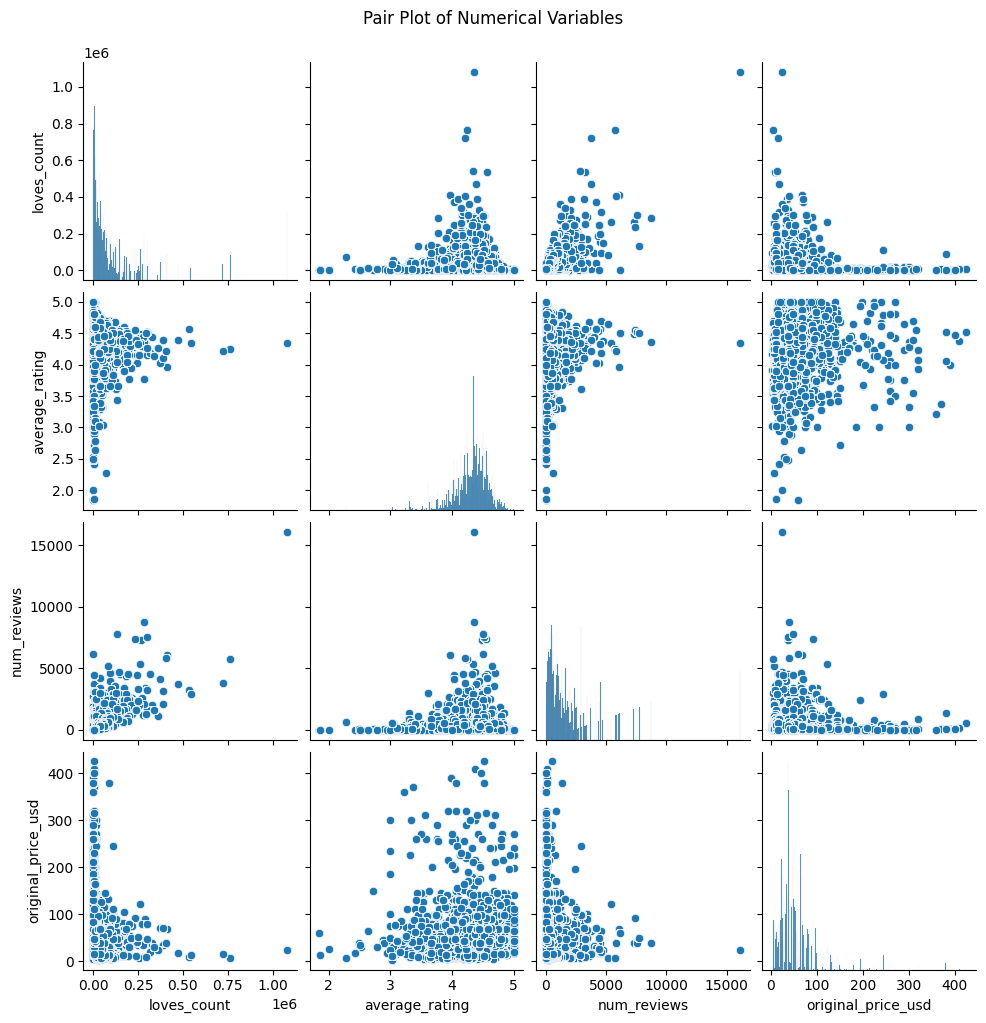

In [ ]:
numerical_cols = ['loves_count', 'average_rating', 'num_reviews', 'original_price_usd']


# Pair Plots
pair_plot = sns.pairplot(merged_df[numerical_cols])
pair_plot.fig.suptitle('Pair Plot of Numerical Variables', y=1.02)  # Adjust y position to prevent overlap
plt.show()


In [ ]:
for i in range(20):
  print(i,np.sum(merged_df['author_id'].value_counts() > i))

0 472401
1 168000
2 84161
3 48763
4 30960
5 20862
6 14883
7 11072
8 8578
9 6914
10 5657
11 4780
12 4125
13 3612
14 3188
15 2870
16 2595
17 2370
18 2160
19 1997


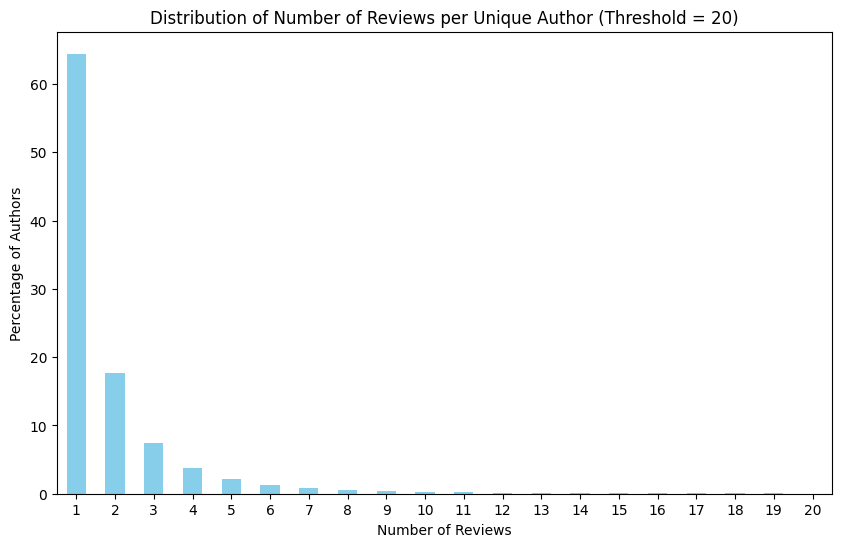

In [ ]:
# Define the upper threshold
upper_threshold = 20

# Calculate the count of reviews per unique author
author_review_counts = merged_df['author_id'].value_counts()

# Filter out authors with more than the upper threshold
author_review_counts_filtered = author_review_counts[author_review_counts <= upper_threshold]

# Calculate percentages
total_authors = len(merged_df['author_id'].unique())
percentages = (author_review_counts_filtered.value_counts() / total_authors) * 100

# Plot the histogram or bar plot
plt.figure(figsize=(10, 6))
percentages.plot(kind='bar', color='skyblue')
plt.title(f'Distribution of Number of Reviews per Unique Author (Threshold = {upper_threshold})')
plt.xlabel('Number of Reviews')
plt.ylabel('Percentage of Authors')
plt.xticks(rotation=0)
plt.show()


In [ ]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
brand_id,930452.0,5517.645412,1492.291267,1063.0000,5337.000000,6073.000000,6234.0000,8.017000e+03
loves_count,930452.0,113343.656612,177116.667619,0.0000,17313.000000,52868.000000,129875.0000,1.081315e+06
average_rating,930452.0,4.306036,0.277300,1.8462,4.162600,4.350800,4.4958,5.000000e+00
num_reviews,930452.0,2156.610187,2626.037602,1.0000,554.000000,1327.000000,2783.0000,1.611800e+04
original_price_usd,930452.0,51.504756,39.578565,3.0000,29.000000,42.000000,65.0000,4.250000e+02
value_price_usd,22543.0,110.720845,45.544326,20.0000,68.000000,102.000000,142.0000,2.100000e+02
sale_price_usd,9163.0,16.845890,10.722002,3.0000,7.000000,18.000000,20.0000,8.500000e+01
limited_edition,930452.0,0.016120,0.125938,0.0000,0.000000,0.000000,0.0000,1.000000e+00
new,930452.0,0.021852,0.146199,0.0000,0.000000,0.000000,0.0000,1.000000e+00
online_only,930452.0,0.090447,0.286822,0.0000,0.000000,0.000000,0.0000,1.000000e+00


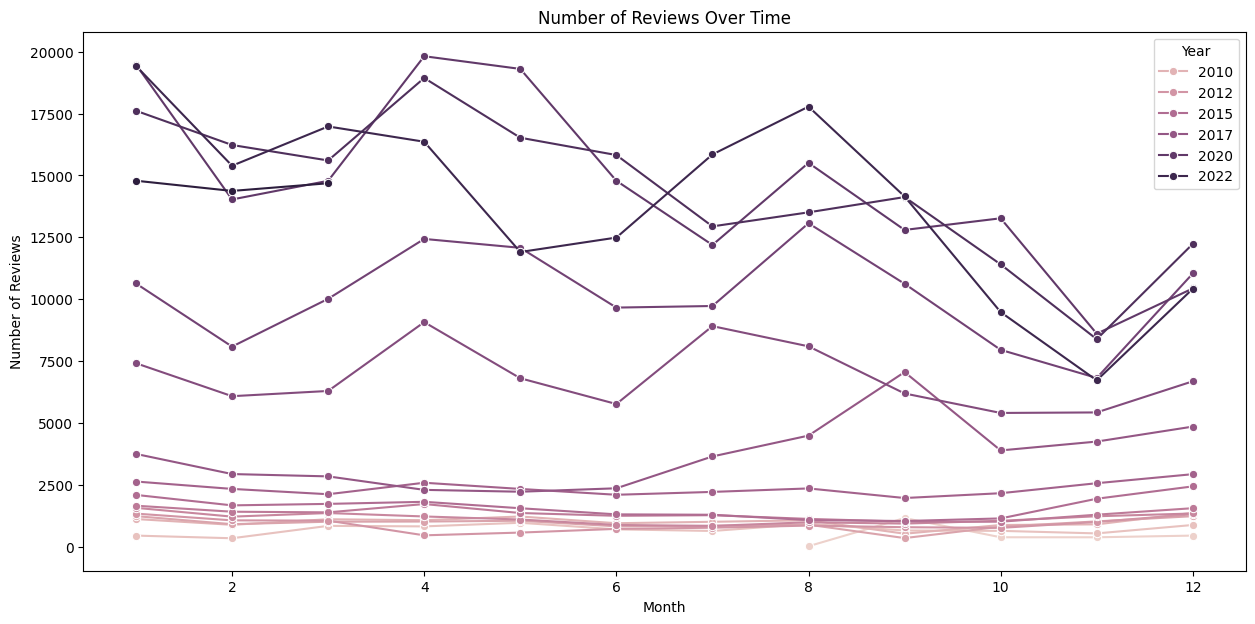

In [73]:
# Temporal Analysis of Reviews
# Convert submission_time to datetime
merged_df['submission_time'] = pd.to_datetime(merged_df['submission_time'], errors='coerce')
# Extract year and month for trend analysis
merged_df['year'] = merged_df['submission_time'].dt.year
merged_df['month'] = merged_df['submission_time'].dt.month
# Plotting the number of reviews over time
time_series = merged_df.groupby(['year', 'month']).size().reset_index(name='counts')
plt.figure(figsize=(15, 7))
sns.lineplot(data=time_series, x='month', y='counts', hue='year', marker='o')
plt.title('Number of Reviews Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.legend(title='Year')
plt.show()

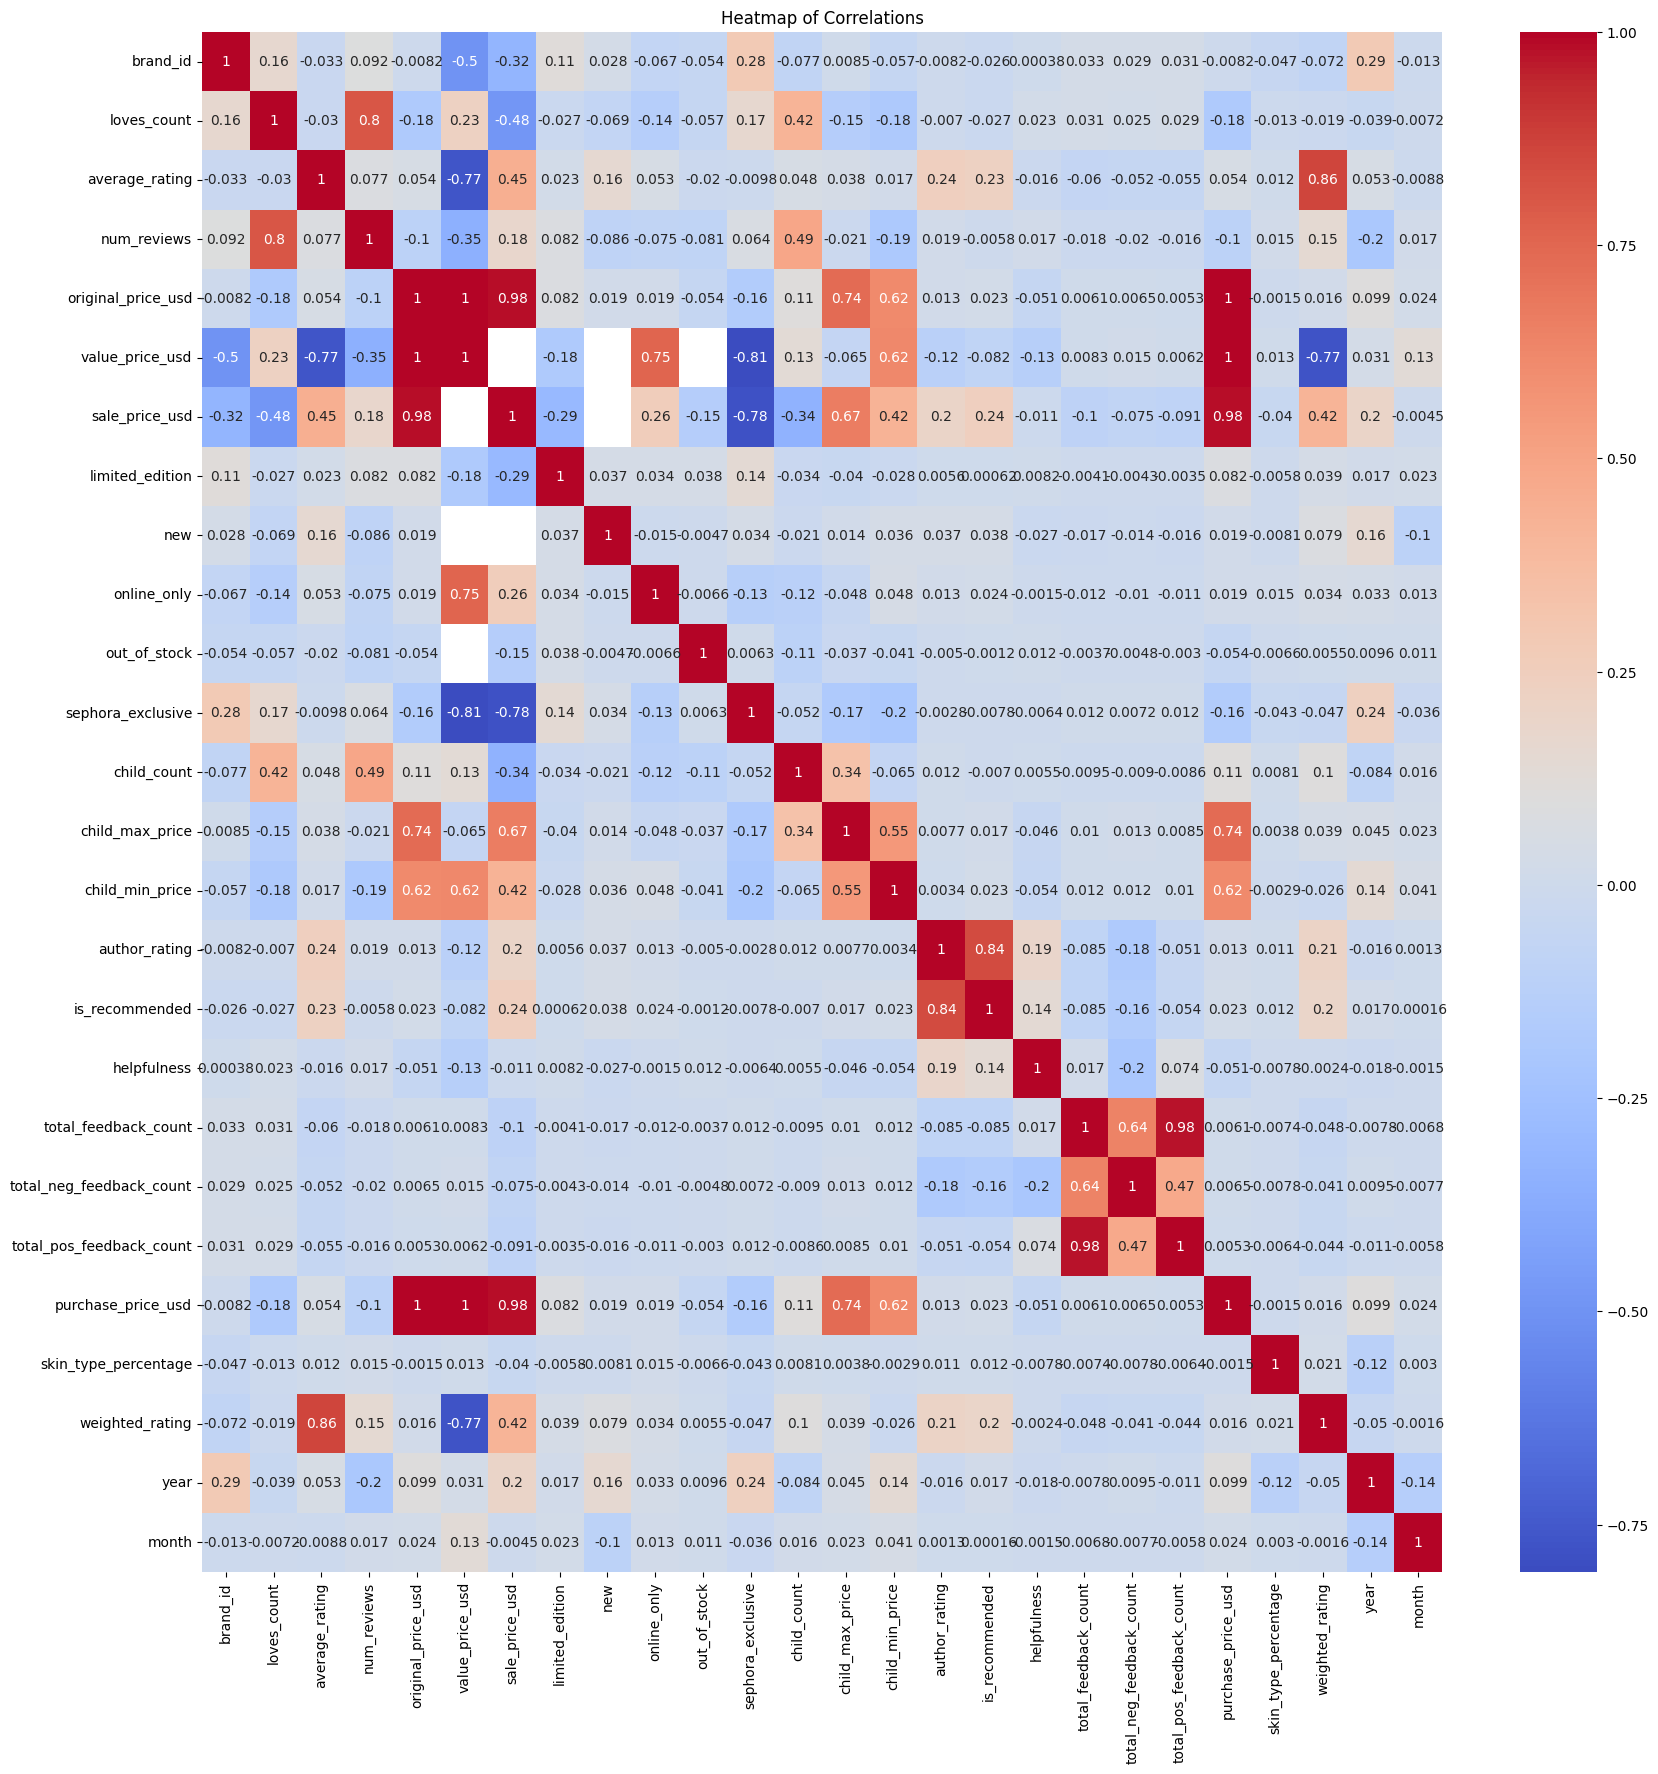

In [75]:
# Heatmap of Correlations
plt.figure(figsize=(20, 20))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlations')
plt.show()